<a href="https://colab.research.google.com/github/reshalfahsi/anchor-free-object-detection/blob/master/AnchorFreeObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Anchor-Free Object Detection**

## **Important Libraries**

### **Install**

In [1]:
!pip install -q --no-cache-dir lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 221.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 268.5 MB/s eta 0:00:00


### **Import**

In [2]:
import os
import re
import io
import cv2
import math
import time
import random
import shutil
import errno
import tarfile
import logging
import warnings
import numpy as np
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import hashlib
import requests

from tqdm import tqdm
from pprint import pprint

try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision.datasets.utils import download_url
from torchvision.models import shufflenet_v2_x0_5, ShuffleNet_V2_X0_5_Weights

try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from torchmetrics.detection.mean_ap import MeanAveragePrecision

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [3]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
os.makedirs("experiment/model", exist_ok=True)
EXPERIMENT_DIR = "experiment/"

In [4]:
IMG_SIZE = {
    'height': 352,
    'width' : 352,
}
INFERENCE_SAMPLE = 3

In [5]:
MAX_EPOCH               = 9 ** 2
BATCH_SIZE              = 6 ** 2
EARLY_STOPPING_PATIENCE = 3 ** 2

In [6]:
MILESTONES = 1. / math.sqrt(MAX_EPOCH) * (
    np.array(
        [m for m in range(int(math.sqrt(MAX_EPOCH)))]
    )
)

In [8]:
LEARNING_RATE    = 1 / 31.4159 * (math.pi / math.e)
MOMENTUM         = 1 / 9.41149 * (math.pi * math.e)
WEIGHT_DECAY     = 1 / 12345.6 * (math.pi + math.e)
REDUCE_LR_FACTOR = 1 / 0.98765 * (math.pi - math.e)

In [9]:
METRIC_TO_MONITOR = "val_loss"
METRIC_MODE       = "min"

In [10]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 680716430


## **Dataset**

### **Prepare**

In [11]:
TEST_2007_URL = (
    "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar"
)

TRAINVAL_2012_URL = (
    "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
)

In [12]:
DOWNLOAD = [
    {
        "filename": "VOCtest_06-Nov-2007.tar",
        "url": TEST_2007_URL,
    },
    {
        "filename": "VOCtrainval_11-May-2012.tar",
        "url": TRAINVAL_2012_URL,
    },
]

In [13]:
# From:
# https://cv.gluon.ai/_downloads/27d447db882ebac8d372e3a834e76496/pascal_voc.py

"""Prepare PASCAL VOC datasets"""

for download in DOWNLOAD:
    download_url(
        url=download['url'],
        root="experiment/dataset",
        filename=download["filename"],
    )
    fullpath = f"experiment/dataset/{download['filename']}"
    with tarfile.open(fullpath) as tar:
        tar.extractall(path="experiment/dataset")

shutil.move(
    os.path.join("experiment/dataset", "VOCdevkit", "VOC2007"),
    os.path.join("experiment/dataset", "VOC2007"),
)
shutil.move(
    os.path.join("experiment/dataset", "VOCdevkit", "VOC2012"),
    os.path.join("experiment/dataset", "VOC2012"),
)
shutil.rmtree(os.path.join("experiment/dataset", "VOCdevkit"))

100%|██████████| 451020800/451020800 [00:15<00:00, 28418003.06it/s]


100%|██████████| 1999639040/1999639040 [01:06<00:00, 30096990.80it/s]


### **Utils**

In [14]:
# From:
# - https://cv.gluon.ai/_modules/gluoncv/data/pascal_voc/detection.html
# - https://github.com/dmlc/gluon-cv/blob/master/gluoncv/data/base.py


class VOCDetection(data.Dataset):
    """Pascal VOC detection Dataset.

    Parameters
    ----------
    root : str, default 'experiment/dataset'
        Path to folder storing the dataset.
    splits : list of tuples, default [(2012, "trainval")]
        List of combinations of (year, name)
        For years, candidates can be: 2007, 2012.
        For names, candidates can be: 'train', 'val', 'trainval', 'test'.
    transform : callable, default None
        A function that takes data and label and transforms them. Refer to
        :doc:`./transforms` for examples.

        A transform function for object detection should take label into
        consideration, because any geometric modification will require label to
        be modified.
    index_map : dict, default None
        In default, the 20 classes are mapped into indices from 0 to 19. We can
        customize it by providing a str to int dict specifying how to map class
        names to indices. Use by advanced users only, when you want to swap the
        orders of class labels.
    preload_label : bool, default True
        If False, then parse and load all labels into memory during
        initialization. It often accelerate speed but require more memory
        usage. Typical preloaded labels took tens of MB. You only need to
        disable it when your dataset is extremely large.
    """

    CLASSES = (
        "aeroplane",
        "bicycle",
        "bird",
        "boat",
        "bottle",
        "bus",
        "car",
        "cat",
        "chair",
        "cow",
        "diningtable",
        "dog",
        "horse",
        "motorbike",
        "person",
        "pottedplant",
        "sheep",
        "sofa",
        "train",
        "tvmonitor",
    )
    inference = False

    def __init__(
        self,
        root="experiment/dataset",
        splits=[(2012, "trainval")],
        transform=None,
        index_map=None,
        preload_label=True,
    ):
        super().__init__()

        self._im_shapes = {}
        self._root = os.path.expanduser(root)
        self._transform = transform
        self._splits = splits

        self._items = self._load_items(splits)

        self._anno_path = os.path.join("{}", "Annotations", "{}.xml")
        self._image_path = os.path.join("{}", "JPEGImages", "{}.jpg")
        self.index_map = index_map or dict(
            zip(
                self.classes,
                range(self.num_class),
            )
        )
        self._label_cache = self._preload_labels() if preload_label else None

    def __str__(self):
        detail = ",".join([str(s[0]) + s[1] for s in self._splits])
        return self.__class__.__name__ + "(" + detail + ")"

    @property
    def classes(self):
        """Category names."""
        try:
            self._validate_class_names(self.CLASSES)
        except AssertionError as e:
            raise RuntimeError("Class names must not contain {}".format(e))
        return type(self).CLASSES

    @property
    def num_class(self):
        """Number of categories."""
        return len(self.classes)

    def __len__(self):
        return 1 if self.inference else len(self._items)

    def set_inference_index(self, idx):
        self.INFERENCE_INDEX = idx

    def get_image_path(self, idx):
        img_id = self._items[idx]
        return self._image_path.format(*img_id)

    @property
    def inference_image(self):
        img_path = self.get_image_path(self.INFERENCE_INDEX)
        return cv2.imread(img_path)

    def __getitem__(self, idx):

        if self.inference:
            idx = self.INFERENCE_INDEX

        img_path = self.get_image_path(idx)

        if not self.inference:
            if self._label_cache:
                label = self._label_cache[idx]
            else:
                label = self._load_label(idx)

        img = cv2.imread(img_path)

        if self._transform is not None:
            if self.inference:
                return self._transform(img)
            else:
                return self._transform(img, label)

        if self.inference:
            return img

        return img, label.copy()

    def _load_items(self, splits):
        """Load individual image indices from splits."""
        ids = []
        for subfolder, name in splits:

            root = os.path.join(
                self._root,
                ("VOC" + str(subfolder))
                if isinstance(subfolder, int) else subfolder,
            )

            lf = os.path.join(root, "ImageSets", "Main", name + ".txt")
            with open(lf, "r") as f:
                ids += [(root, line.strip()) for line in f.readlines()]

        return ids

    def _load_label(self, idx):
        """Parse xml file and return labels."""
        img_id = self._items[idx]

        anno_path = self._anno_path.format(*img_id)

        root = ET.parse(anno_path).getroot()

        size = root.find("size")
        width = float(size.find("width").text)
        height = float(size.find("height").text)

        if idx not in self._im_shapes:
            # store the shapes for later usage
            self._im_shapes[idx] = (width, height)

        label = list()
        for obj in root.iter("object"):

            try:
                difficult = int(obj.find("difficult").text)
            except ValueError:
                difficult = 0

            cls_name = obj.find("name").text.strip().lower()
            if cls_name not in self.classes:
                continue
            cls_id = self.index_map[cls_name]

            xml_box = obj.find("bndbox")
            xmin = float(xml_box.find("xmin").text) - 1
            ymin = float(xml_box.find("ymin").text) - 1
            xmax = float(xml_box.find("xmax").text) - 1
            ymax = float(xml_box.find("ymax").text) - 1

            try:

                self._validate_label(xmin, ymin, xmax, ymax, width, height)
                cx = ((xmin + xmax) / 2.) / width
                cy = ((ymin + ymax) / 2.) / height
                w = (xmax - xmin) / width
                h = (ymax - ymin) / height
                label.append([difficult, cls_id, cx, cy, w, h])

            except AssertionError as e:

                logging.warning("Invalid label at %s, %s", anno_path, e)

        return np.array(label)

    def _validate_label(self, xmin, ymin, xmax, ymax, width, height):
        """Validate labels."""
        assert 0 <= xmin < width, (
            f"xmin must in [0, {width}), given {xmin}"
        )
        assert 0 <= ymin < height, (
            f"ymin must in [0, {height}), given {ymin}"
        )
        assert xmin < xmax <= width, (
            f"xmax must in (xmin, {width}], given {xmax}"
        )
        assert ymin < ymax <= height, (
            f"ymax must in (ymin, {height}], given {ymax}"
        )

    def _validate_class_names(self, class_list):
        """Validate class names."""
        assert all(c.islower() for c in class_list), "uppercase characters"
        stripped = [c for c in class_list if c.strip() != c]
        if stripped:
            warnings.warn(f"white space removed for {stripped}")

    def _preload_labels(self):
        """Preload all labels into memory."""
        logging.debug("Preloading %s labels into memory...", str(self))
        return [self._load_label(idx) for idx in range(len(self))]

In [15]:
# From:
# - https://github.com/dog-qiuqiu/FastestDet/blob/main/utils/datasets.py


""" Utils """


def collate_fn(batch):
    img, label = zip(*batch)
    for i, l in enumerate(label):
        if l.shape[0] > 0:
            l[:, 0] = i
    return torch.stack(img), torch.cat(label, 0)


def random_crop(image, boxes):
    height, width, _ = image.shape
    # random crop image
    cw, ch = random.randint(
        int(width * 0.75), width), random.randint(int(height * 0.75), height)
    cx, cy = random.randint(0, width - cw), random.randint(0, height - ch)

    roi = image[cy:cy + ch, cx:cx + cw]
    roi_h, roi_w, _ = roi.shape

    output = []
    for box in boxes:
        index, category = box[0], box[1]
        bx, by = box[2] * width, box[3] * height
        bw, bh = box[4] * width, box[5] * height

        bx, by = (bx - cx)/roi_w, (by - cy)/roi_h
        bw, bh = bw/roi_w, bh/roi_h

        output.append([index, category, bx, by, bw, bh])

    output = np.array(output, dtype=float)

    return roi, output


def random_narrow(image, boxes):
    height, width, _ = image.shape
    # random narrow
    cw, ch = random.randint(
        width, int(width * 1.25)), random.randint(height, int(height * 1.25))
    cx, cy = random.randint(0, cw - width), random.randint(0, ch - height)

    background = np.ones((ch, cw, 3), np.uint8) * 128
    background[cy:cy + height, cx:cx + width] = image

    output = []
    for box in boxes:
        index, category = box[0], box[1]
        bx, by = box[2] * width, box[3] * height
        bw, bh = box[4] * width, box[5] * height

        bx, by = (bx + cx)/cw, (by + cy)/ch
        bw, bh = bw/cw, bh/ch

        output.append([index, category, bx, by, bw, bh])

    output = np.array(output, dtype=float)

    return background, output


def train_transform(
        img,
        label,
        img_width=IMG_SIZE['width'],
        img_height=IMG_SIZE['height'],
):

    if random.randint(0, 1):
        img, label = random_narrow(img, label)
    else:
        img, label = random_crop(img, label)

    img = cv2.resize(
        img,
        (img_width, img_height),
        interpolation = cv2.INTER_LINEAR,
    )
    img = img.transpose(2,0,1).astype('float32')
    img /= 255.

    return torch.from_numpy(img), torch.from_numpy(label)


def test_transform(
        img,
        label,
        img_width=IMG_SIZE['width'],
        img_height=IMG_SIZE['height'],
):
    img = cv2.resize(
        img,
        (img_width, img_height),
        interpolation = cv2.INTER_LINEAR,
    )
    img = img.transpose(2,0,1).astype('float32')
    img /= 255.

    return torch.from_numpy(img), torch.from_numpy(label)

In [16]:
val_transform = test_transform

## **Model**

### **Utils**

In [17]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

### **Loss**

In [18]:
# From:
# - https://github.com/dog-qiuqiu/FastestDet/blob/main/module/loss.py


class DetectorLoss(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()

        # Define the loss function of class/label
        self.BCEcls = nn.NLLLoss()
        # Define the loss function of objectness
        self.BCEobj = nn.SmoothL1Loss(reduction="none")

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self._eps = epsilon

    def bbox_iou(self, box1, box2, eps=1e-7):
        # Returns the IoU of box1 to box2. box1 is 4, box2 is nx4
        box1 = box1.t()
        box2 = box2.t()

        b1_x1, b1_x2 = box1[0] - box1[2] / 2, box1[0] + box1[2] / 2
        b1_y1, b1_y2 = box1[1] - box1[3] / 2, box1[1] + box1[3] / 2
        b2_x1, b2_x2 = box2[0] - box2[2] / 2, box2[0] + box2[2] / 2
        b2_y1, b2_y2 = box2[1] - box2[3] / 2, box2[1] + box2[3] / 2

        # Intersection area
        inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * (
            torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)
        ).clamp(0)

        # Union Area
        w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
        w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps
        union = w1 * h1 + w2 * h2 - inter + eps
        iou = inter / union

        cw = torch.max(b1_x2, b2_x2) - torch.min(
            b1_x1, b2_x1
        )  # convex (smallest enclosing box) width
        ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height

        # SIoU Loss https://arxiv.org/pdf/2205.12740.pdf
        s_cw = (b2_x1 + b2_x2 - b1_x1 - b1_x2) * 0.5
        s_ch = (b2_y1 + b2_y2 - b1_y1 - b1_y2) * 0.5
        sigma = torch.pow(s_cw**2 + s_ch**2, 0.5)
        sin_alpha_1 = torch.abs(s_cw) / sigma
        sin_alpha_2 = torch.abs(s_ch) / sigma
        threshold = pow(2, 0.5) / 2
        sin_alpha = torch.where(
            sin_alpha_1 > threshold,
            sin_alpha_2,
            sin_alpha_1,
        )
        angle_cost = torch.cos(torch.arcsin(sin_alpha) * 2 - math.pi / 2)
        rho_x = (s_cw / cw) ** 2
        rho_y = (s_ch / ch) ** 2
        gamma = angle_cost - 2
        distance_cost = 2 - torch.exp(gamma * rho_x) - torch.exp(gamma * rho_y)
        omega_w = torch.abs(w1 - w2) / torch.max(w1, w2)
        omega_h = torch.abs(h1 - h2) / torch.max(h1, h2)
        shape_cost = torch.pow(1 - torch.exp(-1 * omega_w), 4) + torch.pow(
            1 - torch.exp(-1 * omega_h), 4
        )
        iou = iou - 0.5 * (distance_cost + shape_cost)

        return iou

    def build_target(self, preds, targets):
        """
        Args:
            preds = [
              batch_size,
              (num_classes + _4_point_bbox_coor + objectness),
              h_grid, w_grid]
            targets = [
              entire_batch_num_label,
              (batch_index + class_idx + 4_point_bbox_coor)
            ]
        """
        N, C, H, W = preds.shape
        # The batch contains labeled data
        gt_box, gt_cls, ps_index = [], [], []
        # The four vertices of each grid are the base points where the center
        # point of the box returns.
        quadrant = torch.tensor(
            [
                [0, 0], [1, 0],
                [0, 1], [1, 1],
            ],
            device=self.device,
        )

        # targets = []
        if targets.shape[0] > 0:

            # Map coordinates to feature map scales
            scale = torch.ones(6).to(self.device)
            scale[2:] = torch.tensor(preds.shape)[[3, 2, 3, 2]]
            gt = targets * scale

            # Extended dimension copy data
            # gt = [
            #    num_quadrant,
            #    entire_batch_num_label,
            #    (batch_index + class_idx + _4_point_bbox_coor)
            # ]
            gt = gt.repeat(4, 1, 1)

            # Filter out-of-bounds coordinates
            # quadrant = [
            #     num_quadrant, entire_batch_num_label, _2_point_grid_coor_delta
            # ]
            # gij = [
            #     num_quadrant, entire_batch_num_label, 2_point_grid_coor_delta
            # ]
            quadrant = quadrant.repeat(gt.size(1), 1, 1).permute(1, 0, 2)
            gij = gt[..., 2:4].long() + quadrant
            j = torch.where(gij < H, gij, 0).min(dim=-1)[0] > 0

            # Foreground position acquisition
            # gi = [<= num_quadrant * entire_batch_num_label]
            # gj = [<= num_quadrant * entire_batch_num_label]
            gi, gj = gij[j].T
            batch_index = gt[..., 0].long()[j]
            ps_index.append((batch_index, gi, gj))

            # Foreground box
            # gbox = [entire_batch_num_bbox, _4_point_bbox_coor]
            gbox = gt[..., 2:][j]
            gt_box.append(gbox)

            # Ground truth class/label
            # gcls = [entire_batch_num_bbox, cls_idx]
            gcls = gt[..., 1].long()[j]
            gt_cls.append(gcls)

        return gt_box, gt_cls, ps_index

    def forward(self, preds, targets):
        # Initialize loss value
        ft = torch.cuda.FloatTensor if preds[0].is_cuda else torch.Tensor
        cls_loss, iou_loss, obj_loss = ft([0]), ft([0]), ft([0])

        # Build ground truth
        gt_box, gt_cls, ps_index = self.build_target(preds, targets)

        pred = preds.permute(0, 2, 3, 1)
        # Objectness classification
        pobj = pred[:, :, :, 0]
        # Detection box regression
        preg = pred[:, :, :, 1:5]
        # Class/label classification
        pcls = pred[:, :, :, 5:]

        N, H, W, C = pred.shape
        tobj = torch.zeros_like(pobj)
        factor = torch.ones_like(pobj) * 0.75

        if len(gt_box) > 0:
            # Calculate regression loss
            b, gx, gy = ps_index[0]
            ptbox = torch.ones((preg[b, gy, gx].shape)).to(self.device)
            ptbox[:, 0] = preg[b, gy, gx][:, 0].tanh() + gx
            ptbox[:, 1] = preg[b, gy, gx][:, 1].tanh() + gy
            ptbox[:, 2] = preg[b, gy, gx][:, 2].sigmoid() * W
            ptbox[:, 3] = preg[b, gy, gx][:, 3].sigmoid() * H

            # Calculate IOU
            iou = self.bbox_iou(ptbox, gt_box[0])
            # Filter
            f = iou > iou.mean()
            b, gy, gx = b[f], gy[f], gx[f]

            # Calculate iou loss
            iou = iou[f]
            iou_loss = (1.0 - iou).mean()

            # Calculate class/label classification loss
            ps = torch.log(pcls[b, gy, gx])
            cls_loss = self.BCEcls(ps, gt_cls[0][f])

            # iou aware
            tobj[b, gy, gx] = iou.float()
            # Count the number of positive samples for each image
            n = torch.bincount(b)
            n = (n[b] / (H * W))
            # for numerical stability
            n = torch.where(torch.eq(n, 0.), self._eps, n)

            factor[b, gy, gx] = (1.0 / n) * 0.25

        # Calculate objectness classification loss
        obj_loss = (self.BCEobj(pobj, tobj) * factor).mean()

        # Calculate total loss
        loss = (iou_loss * 8) + (obj_loss * 16) + cls_loss

        return loss

### **Module**

In [19]:
class PWConv(nn.Module):
    def __init__(self, in_channels, out_channels, act=True):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.act = act

    def forward(self, x):
        if self.act:
           return F.relu(self.conv(x))
        else:
           return self.conv(x)

In [20]:
class DWConv(nn.Module):
    def __init__(self, channels, kernel_size=3, stride=1, act=True):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(
                channels,
                channels,
                kernel_size,
                stride=stride,
                padding=kernel_size//2,
                groups=channels,
                bias=False,
            ),
            nn.BatchNorm2d(channels),
        )
        self.act = act

    def forward(self, x):
        if self.act:
           return F.relu(self.conv(x))
        else:
           return self.conv(x)

In [23]:
class Head(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = nn.Sequential(
            DWConv(in_channels, 5),
            PWConv(in_channels, out_channels, act=False),
        )

    def forward(self, x):
        return self.conv(x)

In [24]:
class SPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = PWConv(in_channels, out_channels)

        self.S1 = DWConv(out_channels, 5)

        self.S2 = nn.Sequential(
            DWConv(out_channels, 5),
            DWConv(out_channels, 5),
        )

        self.S3 = nn.Sequential(
            DWConv(out_channels, 5),
            DWConv(out_channels, 5),
            DWConv(out_channels, 5),
        )

        self.output = PWConv(3 * out_channels, out_channels, act=False)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)

        y1 = self.S1(x)
        y2 = self.S2(x)
        y3 = self.S3(x)

        y = torch.cat((y1, y2, y3), dim=1)
        y = F.relu(x + self.output(y))

        return y

In [25]:
class DetectHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv = PWConv(in_channels, in_channels)

        self.obj_layers = Head(in_channels, 1)
        self.reg_layers = Head(in_channels, 4)
        self.cls_layers = Head(in_channels, num_classes)

    def forward(self, x):
        x = self.conv(x)

        obj = torch.sigmoid(self.obj_layers(x))
        reg = self.reg_layers(x)
        cls = F.softmax(self.cls_layers(x), dim=1)

        return torch.cat((obj, reg, cls), dim=1)

### **Wrapper**

In [26]:
class FastestDet(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.batch_size = BATCH_SIZE
        self.lr = LEARNING_RATE
        self.max_epoch = MAX_EPOCH
        self.lr_now = self.lr * 1e3

        num_classes = len(VOCDetection.CLASSES)
        stage_out_channels = [-1, 24, 48, 96, 192]

        self.backbone = shufflenet_v2_x0_5(
            weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1
        )
        self.spp = SPP(sum(stage_out_channels[-3:]), stage_out_channels[-2])
        self.detect_head = DetectHead(stage_out_channels[-2], num_classes)

        del self.backbone.conv5, self.backbone.fc

        self.loss_fn = DetectorLoss()

        self.test_mAP = MeanAveragePrecision(box_format="cxcywh")

        self.automatic_optimization = False

        self.train_loss = list()
        self.val_loss = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x, inference=False):

        if inference:
            x = np.array(x)
            H, W = x.shape[0], x.shape[1]
            x = self.preprocessing(x).unsqueeze(0).to(self.device)

        P1 = self.backbone.stage2(self.backbone.maxpool(self.backbone.conv1(x)))
        P2 = self.backbone.stage3(P1)
        P3 = self.backbone.stage4(P2)

        P3 = F.interpolate(P3, scale_factor=2)
        P1 = F.avg_pool2d(P1, kernel_size=3, stride=2, padding=1)
        P = torch.cat((P1, P2, P3), dim=1)
        y = self.detect_head(self.spp(P))

        if inference:
            y = self.postprocessing(y)

            boxes  = np.array([])
            scores = None
            labels = None

            if y[0].shape[0] > 0:
                boxes = y[0][:, :4].data.cpu().numpy()
                boxes[:, 0] *= W
                boxes[:, 1] *= H
                boxes[:, 2] *= W
                boxes[:, 3] *= H

                scores = y[0][:, 4].data.cpu().numpy()

                labels = y[0][:, 5].int().data.cpu().numpy()

            y = dict(
                boxes=boxes,
                scores=scores,
                labels=labels,
            )

        return y

    def convert_to_cxcywh(self, boxes):
        """Changes the box format to center, width and height.

        Arguments:
          boxes: A tensor of rank 2 or higher with a shape of
          `(..., num_boxes, 4)` representing bounding boxes where each box
          is of the format `[xmin, ymin, xmax, ymax]`.

        Returns:
          converted boxes with shape same as that of boxes.
        """
        return torch.cat(
            [
                (boxes[..., :2] + boxes[..., 2:]) / 2.0,
                boxes[..., 2:] - boxes[..., :2]
            ],
            axis=-1,
        )

    def preprocessing(self, img):
        img = cv2.resize(
            img,
            (IMG_SIZE['width'], IMG_SIZE['height']),
            interpolation = cv2.INTER_LINEAR,
        )
        img = img.transpose(2,0,1).astype('float32')
        img /= 255.

        return torch.from_numpy(img)

    def postprocessing(self, preds, conf_thresh=0.65, nms_thresh=0.45):
        total_bboxes, output_bboxes = list(), list()
        # 将特征图转换为检测框的坐标
        N, C, H, W = preds.shape
        bboxes = torch.zeros((N, H, W, 6))
        pred = preds.permute(0, 2, 3, 1)
        # 前背景分类分支
        pobj = pred[:, :, :, 0].unsqueeze(dim=-1)
        # 检测框回归分支
        preg = pred[:, :, :, 1:5]
        # 目标类别分类分支
        pcls = pred[:, :, :, 5:]

        # 检测框置信度
        bboxes[..., 4] = (
            pobj.squeeze(-1) ** 0.6) * (pcls.max(dim=-1)[0] ** 0.4)
        bboxes[..., 5] = pcls.argmax(dim=-1)

        # 检测框的坐标
        gy, gx = torch.meshgrid([torch.arange(H), torch.arange(W)])
        bw, bh = preg[..., 2].sigmoid(), preg[..., 3].sigmoid()
        bcx = (preg[..., 0].tanh() + gx.to(self.device)) / W
        bcy = (preg[..., 1].tanh() + gy.to(self.device)) / H

        # cx,cy,w,h = > x1,y1,x2,y1
        x1, y1 = bcx - 0.5 * bw, bcy - 0.5 * bh
        x2, y2 = bcx + 0.5 * bw, bcy + 0.5 * bh

        bboxes[..., 0], bboxes[..., 1] = x1, y1
        bboxes[..., 2], bboxes[..., 3] = x2, y2
        bboxes = bboxes.reshape(N, H * W, 6)
        total_bboxes.append(bboxes)

        batch_bboxes = torch.cat(total_bboxes, 1)

        # 对检测框进行NMS处理
        for p in batch_bboxes:
            output, temp = list(), list()
            b, s, c = list(), list(), list()
            # 阈值筛选
            t = p[:, 4] > conf_thresh
            pb = p[t]
            for bbox in pb:
                obj_score = bbox[4]
                category = bbox[5]
                x1, y1 = bbox[0], bbox[1]
                x2, y2 = bbox[2], bbox[3]
                s.append([obj_score])
                c.append([category])
                b.append([x1, y1, x2, y2])
                temp.append([x1, y1, x2, y2, obj_score, category])
            # Torchvision NMS
            if len(b) > 0:
                b = torch.Tensor(b).to(self.device)
                c = torch.Tensor(c).squeeze(1).to(self.device)
                s = torch.Tensor(s).squeeze(1).to(self.device)
                keep = torchvision.ops.batched_nms(b, s, c, nms_thresh)
                for i in keep:
                    output.append(temp[i])
            output_bboxes.append(torch.Tensor(output).to(self.device))
        return output_bboxes

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)

        self.train_loss_recorder.update(loss.data)

    def on_train_epoch_end(self):
        sch = self.lr_schedulers()
        sch.step()

        self.train_loss.append(
            self.train_loss_recorder.show().data.cpu().numpy(),
        )
        self.train_loss_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)

        if self.sanity_check_counter == 0:
            self.log("val_loss", loss, prog_bar=True)
            self.val_loss_recorder.update(loss.data)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            loss = self.val_loss_recorder.show().data.cpu().numpy()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now != lr_now_:
                self.lr_now = lr_now_
                str_report = f"[{MODEL_NAME}] Learning Rate Changed: {lr_now_}"
                str_report += f"- Epoch: {self.current_epoch}"
                print(str_report)
            self.val_loss.append(loss)
            self.val_loss_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)

        y_hat = self.postprocessing(y_hat)

        pred = list()
        target = list()

        for b in range(len(y_hat)):
            try:
                pred.append(
                    dict(
                        boxes=self.convert_to_cxcywh(y_hat[b][:, :4]),
                        scores=y_hat[b][:, 4],
                        labels=y_hat[b][:, 5].int(),
                    )
                )
            except:
                pred.append(
                    dict(
                        boxes=torch.tensor([[0., 0., 0., 0.]]).to(self.device),
                        scores=torch.tensor([0.]).to(self.device),
                        labels=torch.tensor([0.]).to(self.device).int(),
                    )
                )

        gt_batch_now = 0
        per_target_boxes = list()
        per_target_labels = list()

        for obj in y:
            if gt_batch_now == obj[0].data.cpu().numpy().tolist():
                per_target_boxes.append(obj[2:].data.cpu().numpy().tolist())
                per_target_labels.append(obj[1].data.cpu().numpy().tolist())
            else:
                target.append(
                    dict(
                        boxes=torch.tensor(per_target_boxes).to(self.device),
                        labels=torch.tensor(per_target_labels).to(
                            self.device
                        ).int()
                    )
                )
                per_target_boxes = list()
                per_target_labels = list()
                gt_batch_now = obj[0].data.cpu().numpy().tolist()

                per_target_boxes.append(obj[2:].data.cpu().numpy().tolist())
                per_target_labels.append(obj[1].data.cpu().numpy().tolist())

        target.append(
            dict(
                boxes=torch.tensor(per_target_boxes).to(self.device),
                labels=torch.tensor(per_target_labels).to(self.device).int()
            )
        )

        self.test_mAP.update(pred, target)
        mAP = self.test_mAP.compute()['map'].data.detach().cpu()

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_mAP@0.5:0.95", mAP, prog_bar=True, logger=True)

    def on_train_end(self):

        # Loss
        loss_img_file = f"experiment/training/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.train_loss, color = 'r', label='train')
        plt.plot(self.val_loss, color = 'b', label='validation')
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        train_dataset = VOCDetection(
            splits=[(2012, 'train')],
            transform=train_transform,
        )
        return data.DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=collate_fn,
            drop_last=True,
            num_workers=2,
            persistent_workers=True,
        )

    def val_dataloader(self):
        val_dataset = VOCDetection(
            splits=[(2012, 'val')],
            transform=val_transform,
        )
        return data.DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            drop_last=False,
            num_workers=2,
            persistent_workers=True
        )

    def test_dataloader(self):
        test_dataset = VOCDetection(
            splits=[(2007, 'test')],
            transform=test_transform,
        )
        return data.DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            drop_last=False,
            num_workers=2,
            persistent_workers=True
        )

    def configure_optimizers(self):
        optimizer = optim.SGD(
            self.parameters(),
            lr=self.lr,
            momentum=MOMENTUM,
            weight_decay=WEIGHT_DECAY,
            nesterov=True,
        )

        lr_scheduler = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[int(self.max_epoch * ms) for ms in MILESTONES],
                gamma=REDUCE_LR_FACTOR,
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

In [27]:
MODEL_NAME = FastestDet.__name__
MODEL = FastestDet
BEST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    "model",
    f"{MODEL_NAME}_best.ckpt",
)

## **Training**

INFO: Seed set to 680716430
INFO:lightning.fabric.utilities.seed:Seed set to 680716430
Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


FastestDet


100%|██████████| 5.28M/5.28M [00:00<00:00, 64.5MB/s]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type                 | Params
-----------------------------------------------------
0 | backbone    | ShuffleNetV2         | 143 K 
1 | spp         | SPP                  | 75.8 K
2 | detect_head | DetectHead           | 19.6 K
3 | loss_fn     | DetectorLoss         | 0     
4 | test_mAP   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[FastestDet] Learning Rate Changed: 0.015767476467199715- Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[FastestDet] Learning Rate Changed: 0.006758004833250608- Epoch: 9


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[FastestDet] Learning Rate Changed: 0.0028965084819530178- Epoch: 18


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[FastestDet] Learning Rate Changed: 0.0012414553693046548- Epoch: 27


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[FastestDet] Learning Rate Changed: 0.0005320928433588325- Epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

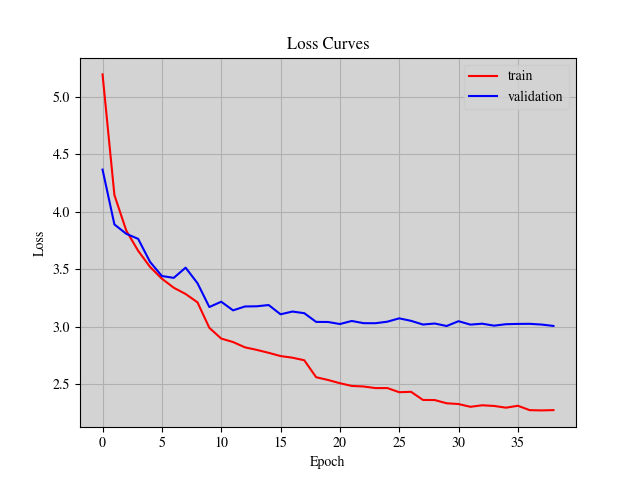

<Figure size 640x480 with 0 Axes>

In [28]:
def _train_loop():
    seed_everything(SEED, workers=True)

    print(MODEL_NAME)
    model = MODEL()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=f"{EXPERIMENT_DIR}/model",
        mode=METRIC_MODE,
        filename=f"{MODEL_NAME}_best",
    )
    callbacks.append(checkpoint)

    early_stopping = EarlyStopping(
        monitor=METRIC_TO_MONITOR,
        min_delta=0.00,
        patience=EARLY_STOPPING_PATIENCE,
        verbose=False,
        mode=METRIC_MODE,
    )
    callbacks.append(early_stopping)

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=MAX_EPOCH,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()

## **Testing**

In [29]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = MODEL()
    trainer.test(model=model, ckpt_path=BEST_MODEL_PATH)

_test_loop()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at experiment/model/FastestDet_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at experiment/model/FastestDet_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at experiment/model/FastestDet_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights fr

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     3.057867343224112     │
│     test_mAP@0.5:0.95     │    0.15306814014911652    │
└───────────────────────────┴───────────────────────────┘

## **Inference**

### **Utils**

In [30]:
# From:
# - https://github.com/dmlc/gluon-cv/blob/master/gluoncv/utils/viz/image.py
# - https://cv.gluon.ai/_modules/gluoncv/utils/viz/bbox.html

"""Visualize image."""


def plot_image(img, ax=None, reverse_rgb=False):
    """Visualize image.

    Parameters
    ----------
    img : numpy.ndarray
        Image with shape `H, W, 3`.
    ax : matplotlib axes, optional
        You can reuse previous axes if provided.
    reverse_rgb : bool, optional
        Reverse RGB<->BGR orders if `True`.

    Returns
    -------
    matplotlib axes
        The ploted axes.

    Examples
    --------

    from matplotlib import pyplot as plt
    ax = plot_image(img)
    plt.show()
    """
    fig = None
    from matplotlib import pyplot as plt
    if ax is None:
        # create new axes
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 1, 1)

    img = img.copy()
    if reverse_rgb:
        img[:, :, (0, 1, 2)] = img[:, :, (2, 1, 0)]
    ax.imshow(img.astype(np.uint8))
    return ax, fig


def plot_bbox(img, bboxes, scores=None, labels=None, thresh=0.5,
              class_names=None, colors=None, ax=None,
              reverse_rgb=True, absolute_coordinates=True,
              linewidth=3.5, fontsize=12):
    """Visualize bounding boxes.

    Parameters
    ----------
    img : numpy.ndarray
        Image with shape `H, W, 3`.
    bboxes : numpy.ndarray
        Bounding boxes with shape `N, 4`. Where `N` is the number of boxes.
    scores : numpy.ndarray, optional
        Confidence scores of the provided `bboxes` with shape `N`.
    labels : numpy.ndarray, optional
        Class labels of the provided `bboxes` with shape `N`.
    thresh : float, optional, default 0.5
        Display threshold if `scores` is provided. Scores with less than
        `thresh` will be ignored in display, this is visually more elegant
        if you have a large number of bounding boxes with very small scores.
    class_names : list of str, optional
        Description of parameter `class_names`.
    colors : dict, optional
        You can provide desired colors as {0: (255, 0, 0), 1:(0, 255, 0), ...},
        otherwise random colors will be substituted.
    ax : matplotlib axes, optional
        You can reuse previous axes if provided.
    reverse_rgb : bool, optional
        Reverse RGB<->BGR orders if `True`.
    absolute_coordinates : bool
        If `True`, absolute coordinates will be considered, otherwise
        coordinates are interpreted as in range(0, 1).
    linewidth : float, optional, default 3.5
        Line thickness for bounding boxes.
    fontsize : int, optional, default 12
        Font size for display of class labels and threshold.

    Returns
    -------
    matplotlib axes
        The ploted axes.

    """
    if labels is not None and not len(bboxes) == len(labels):
        raise ValueError('The length of labels and bboxes mismatch, {} vs {}'
                         .format(len(labels), len(bboxes)))
    if scores is not None and not len(bboxes) == len(scores):
        raise ValueError('The length of scores and bboxes mismatch, {} vs {}'
                         .format(len(scores), len(bboxes)))

    ax, fig = plot_image(img, ax=ax, reverse_rgb=reverse_rgb)
    ax.axis('off')

    if len(bboxes) < 1:
        return ax, fig

    if not absolute_coordinates:
        # convert to absolute coordinates using image shape
        height = img.shape[0]
        width = img.shape[1]
        bboxes[:, (0, 2)] *= width
        bboxes[:, (1, 3)] *= height

    # use random colors if None is provided
    if colors is None:
        colors = dict()
    for i, bbox in enumerate(bboxes):
        if scores is not None and scores.flat[i] < thresh:
            continue
        if labels is not None and labels.flat[i] < 0:
            continue
        cls_id = int(labels.flat[i]) if labels is not None else -1
        if cls_id not in colors:
            if class_names is not None:
                colors[cls_id] = plt.get_cmap('hsv')(cls_id / len(class_names))
            else:
                colors[cls_id] = (
                    random.random(),
                    random.random(),
                    random.random(),
                )
        xmin, ymin, xmax, ymax = [int(x) for x in bbox]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                             ymax - ymin, fill=False,
                             edgecolor=colors[cls_id],
                             linewidth=linewidth)
        ax.add_patch(rect)
        if class_names is not None and cls_id < len(class_names):
            class_name = class_names[cls_id]
        else:
            class_name = str(cls_id) if cls_id >= 0 else ''
        score = '{:.3f}'.format(scores.flat[i]) if scores is not None else ''
        if class_name or score:
            ax.text(xmin, ymin - 2,
                    '{:s} {:s}'.format(class_name, score),
                    bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                    fontsize=fontsize, color='white')
    return ax, fig

### **Initialize**

In [191]:
model = MODEL.load_from_checkpoint(BEST_MODEL_PATH)
model.eval()

InferenceDataset = VOCDetection(
    splits=[(2007, 'test')],
    preload_label=False,
)
InferenceDataset.inference = True

### **Result**

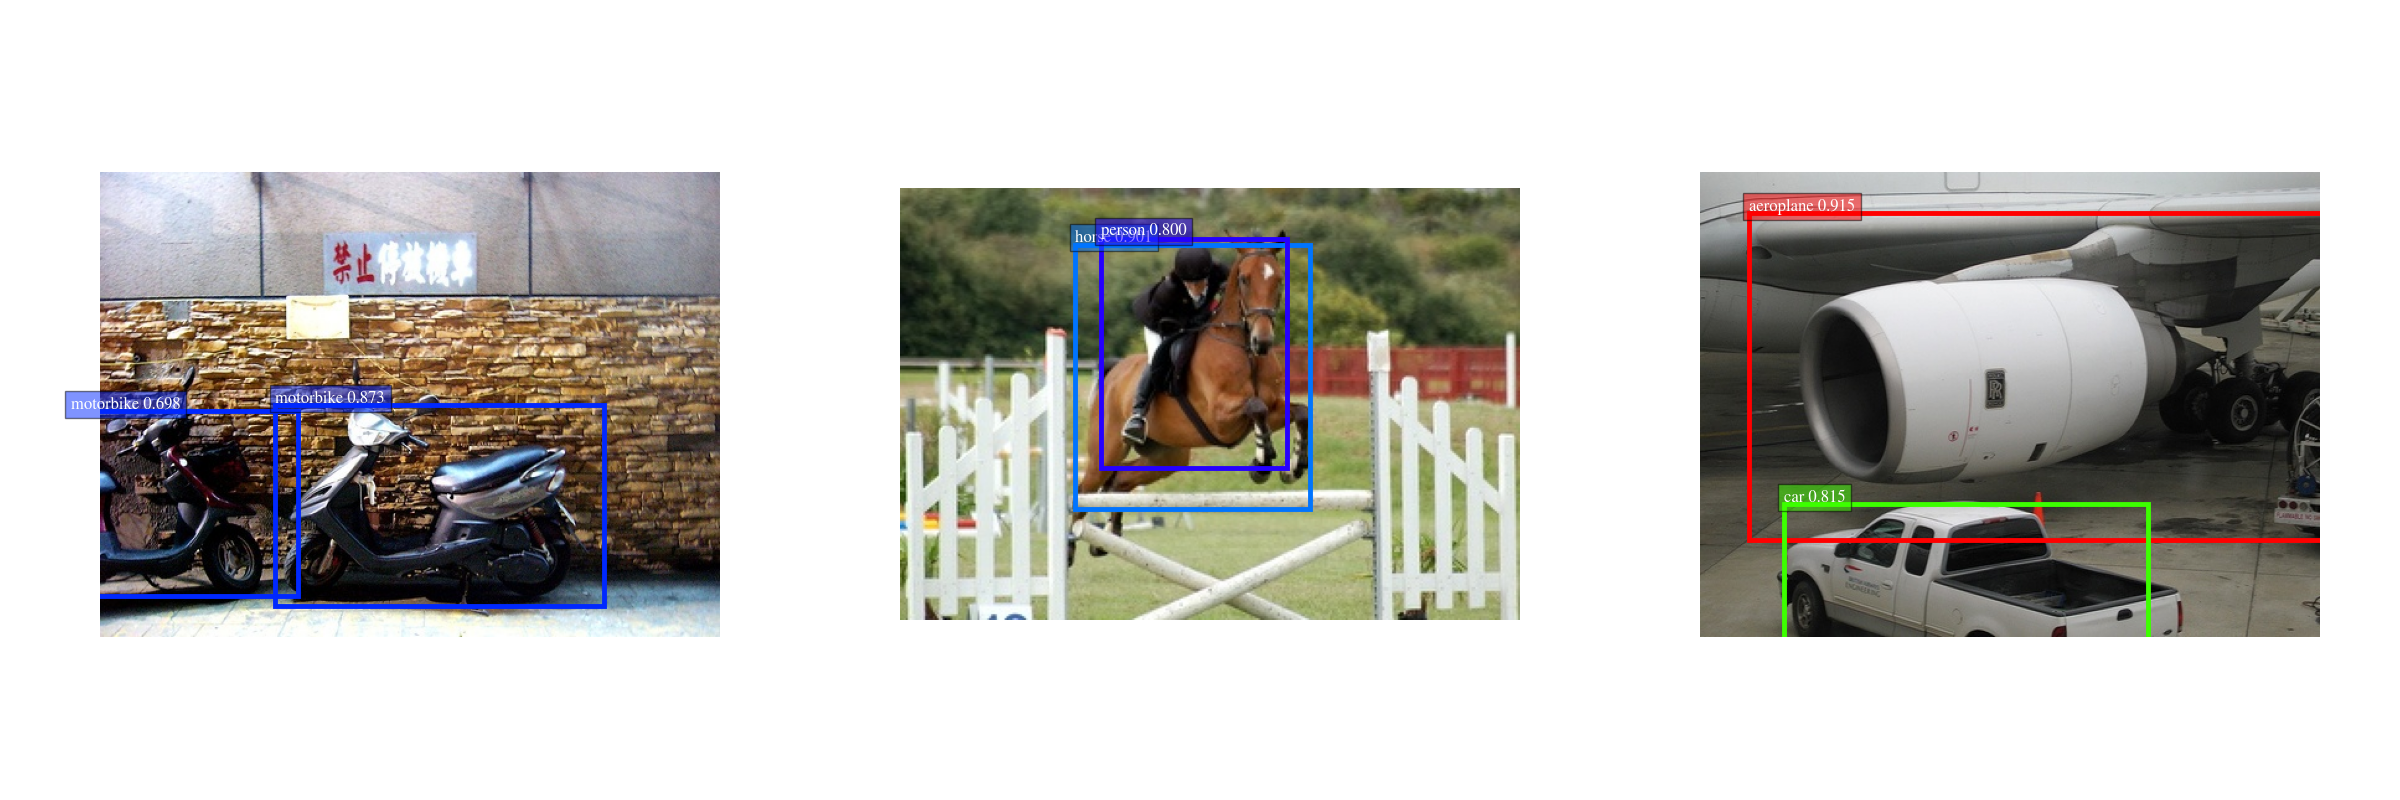

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

In [192]:
img_list = list()

TEMP_INFERENCE_FILE_IMAGE_RESULT = (
    f"{EXPERIMENT_DIR}/{MODEL_NAME}_inference.png"
)

N_SAMPLE = len(InferenceDataset._items)
SELECTED_SAMPLE = [
    random.randint(0, N_SAMPLE - 1) for _ in range(INFERENCE_SAMPLE)
]

for sample_idx in SELECTED_SAMPLE:

    InferenceDataset.set_inference_index(sample_idx)
    inference_image = InferenceDataset.inference_image

    output = model(inference_image, inference=True)

    ax, fig = plot_bbox(
        inference_image,
        output["boxes"],
        scores=output["scores"],
        labels=output["labels"],
        class_names=list(VOCDetection.CLASSES),
    )
    plt.savefig(TEMP_INFERENCE_FILE_IMAGE_RESULT)
    plt.clf()
    img_list.append(
        cv2.imread(TEMP_INFERENCE_FILE_IMAGE_RESULT)
    )

cv2_imshow(cv2.hconcat(img_list))
del InferenceDataset
os.remove(TEMP_INFERENCE_FILE_IMAGE_RESULT)